In [67]:
import re
import pandas as pd
pd.options.mode.chained_assignment = None
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import string
from datetime import datetime
from utils.database_util import DatabaseUtil
from matplotlib import pyplot as plt
import seaborn as sns
import quandl
from sklearn import preprocessing
%matplotlib inline
pd.options.display.float_format = '{:,.0f}'.format
%config IPCompleter.greedy=True

# Data Cleaning

In [15]:
# connect to the sqlite3 db file, utilizing the customized module
DBUtil = DatabaseUtil()
conn = DBUtil.get_conn()

* clean tweets data

In [16]:
df_t = pd.read_sql('select * from tweets', conn)

In [17]:
# tweets df before cleaning
df_t.sample(5)

,id,author,tweet,time,type
33431,1128335944480903168,zerohedge,LAVROV SAYS HE HANDED POMPEO MEMORANDUM ON US ...,2019-05-14 16:27:07,biznews
19119,1085222117258473472,bildgta,BILD supports the proposed changes to the #Gro...,2019-01-15 17:08:09,realtor
22776,1109137797867282432,CREA_ACI,Article of the Day: @globeandmail – MCLISTER: ...,2019-03-22 17:00:32,realtor
22344,1106284167568883712,IBDinvestors,Indexes Mostly Unchanged As Apple Leads Dow Jo...,2019-03-14 20:01:13,biznews
34551,1128657983116910592,YahooFinance,The US-China trade war is 'difficult to handic...,2019-05-15 13:46:47,biznews


In [18]:
# twitter text processing and cleaning function
def process_words(raw, remove_punc=False, stem=False):
    link_pattern = [
        r'(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*$',
    ]
    clean = raw.lower().strip()
    for ptn in link_pattern:
        clean = re.sub(ptn, '', clean)
    if remove_punc:
        nopunc = [c for c in clean if c not in string.punctuation]
        raw = ''.join(nopunc)

    stopwords_list = []
    stopwords_list_en = set(stopwords.words('english'))
    stopwords_list_fr = set(stopwords.words('french'))
    stopwords_list.extend(stopwords_list_en)
    stopwords_list.extend(stopwords_list_fr)
   
    nostop = [w for w in raw.split() if w.lower() not in stopwords_list]
    if stem:
        stemmer = PorterStemmer()
        return ' '.join([stemmer.stem(t) for t in nostop])
    else:
        return ' '.join(nostop)

In [19]:
df_t['tweet_clean'] = df_t['tweet'].apply(lambda t: process_words(t, remove_punc=True))
# transform tweet timestamp from string format to datetime
df_t['date'] = df_t['time'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
df_t['date'] = df_t['date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))
df_t.drop(['time','tweet'],axis = 1, inplace=True)

In [20]:
# tweets df after cleaning
df_t.sample(5)

,id,author,type,tweet_clean,date
32212,1127951405011165184,TheEconomist,biznews,today china warned trump administration “never...,2019-05-13
24316,1115286987206995968,CMHC_ca,realtor,question housing affordability tune instagram ...,2019-04-08
20978,1098719767060332544,NewHomeBuyers,realtor,see much home reno budget set aside emergencie...,2019-02-21
14466,1035162333855633408,KW_REALTORS,realtor,new initiative offers jobs homeless bridges sh...,2018-08-30
3619,773988596407676928,condobusiness,realtor,record high bc home sales expected 2017 bc bri...,2016-09-08


In [21]:
# subsetting the dataframe, grouping by tweets categories
news = df_t[df_t['type'] == 'biznews']
realtor = df_t[df_t['type'] == 'realtor']
searched = df_t[df_t['type'] == 'search']

* clean RealMaster data

In [22]:
df_praw = pd.read_sql('select * from realmaster', conn)

In [23]:
# web df before cleaning
df_praw.sample(5)

,listID,address,ask,city,proptype
2057,E4452723,834 Grand Ridge Ave Oshawa Ontario L1K2T8,649900,Oshawa,Detached
3425,N4449475,19 Poetry Dr Vaughan Ontario L4H 3P8,835000,Vaughan,Townhouse
2186,E4387403,2490 Bromus Path Oshawa Ontario L1L 0H4,525000,Oshawa,Townhouse
2358,E4436730,1792 Carousel Mews Pickering Ontario L1X0C1,648888,Pickering,Townhouse
3065,C4444753,186 Apache Tr Toronto Ontario M2H2J2,729000,Toronto,Bungalow


In [24]:
def get_postal(s):
    p = re.findall('[A-Z]\d[A-Z]\s?\d[A-Z]\d',s)
    if len(p) > 0:
        return p[0].replace(' ','')
    else:
        return None

In [25]:
df_p = df_praw.copy()

In [26]:
# spin out postal code
df_p['postal'] = df_p['address'].apply(lambda a: get_postal(a))

In [27]:
# clean city name ('Richmond%20Hill')
df_p['city'] = df_p['city'].apply(lambda c:c.replace('%20',' '))

In [28]:
# spin street address out of original raw format
def spin_address(df,col1,col2):
    df['bind'] = df[[col1,col2]].apply(tuple,axis=1)
    df['street'] = df['bind'].apply(lambda t: t[0].split(t[1])[0])
    new_df = df[['listID','proptype','ask','street','city','postal']]
    return new_df

In [29]:
df_p = spin_address(df_p,'address','city')

In [30]:
# web df after cleaning
df_p.sample(5)

,listID,proptype,ask,street,city,postal
3340,N4446068,Detached,998888,8 Irish Moss Crt,Vaughan,L4L3W8
935,N4405252,Detached,2490000,3 Treeline Crt,Markham,L3S3T8
2108,E4453314,Detached,739990,348 Preston Dr,Oshawa,L1J6Y7
689,H4049640,Apartment,699900,C 366 Bay Street N,Hamilton,L8L1M7
2918,C4339928,Loft,1399000,386 Yonge St,Toronto,M5B0A5


* clean and filter CMHC data

In [31]:
# Canadian Mortgage and Housing Corporation - Average, Median and Price Percentiles for Unabsorbed Homeowner and Condominium Units (Ontario)
cmhc_raw = pd.read_sql('select * from cmhc',con=conn)

In [32]:
#CMHC data before cleaning
cmhc_raw.sample(5)

,Date,1st 20%,2nd 40%,3rd 60%,4th 80%,Median,Average,Units
233,2009-06-30 00:00:00.000000,"275,000","340,000","410,000","516,000","375,000","437,312","1,573"
117,1999-10-31 00:00:00.000000,"145,000","170,000","200,000","270,000","180,000","223,908","1,898"
103,1998-08-31 00:00:00.000000,"140,000","160,000","180,000","240,000","170,000","207,595","1,581"
147,2002-04-30 00:00:00.000000,"172,000","200,000","230,000","290,000","210,000","253,078","1,721"
323,2016-12-31 00:00:00.000000,"345,000","430,000","540,000","929,000","490,000","784,170","1,302"


In [33]:
cmhc_raw['Date'] = cmhc_raw['Date'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
cmhc_raw['Date'] = cmhc_raw['Date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))

In [34]:
cmhc_stat = cmhc_raw[cmhc_raw['Date']>= datetime(2019,1,1)]

In [35]:
# after cleaning and filter
cmhc_stat

,Date,1st 20%,2nd 40%,3rd 60%,4th 80%,Median,Average,Units
347,2019-01-31,"440,000","555,000","670,000","1,260,000","620,000","928,256","1,413"
348,2019-02-28,"440,000","555,000","670,000","1,100,000","620,000","899,072","1,460"
349,2019-03-31,"450,000","575,000","690,000","1,125,000","630,000","924,375","1,471"
350,2019-04-30,"465,000","585,000","700,000","1,330,000","645,000","971,201","1,383"


# Exploratory Analysis

## Sentiment

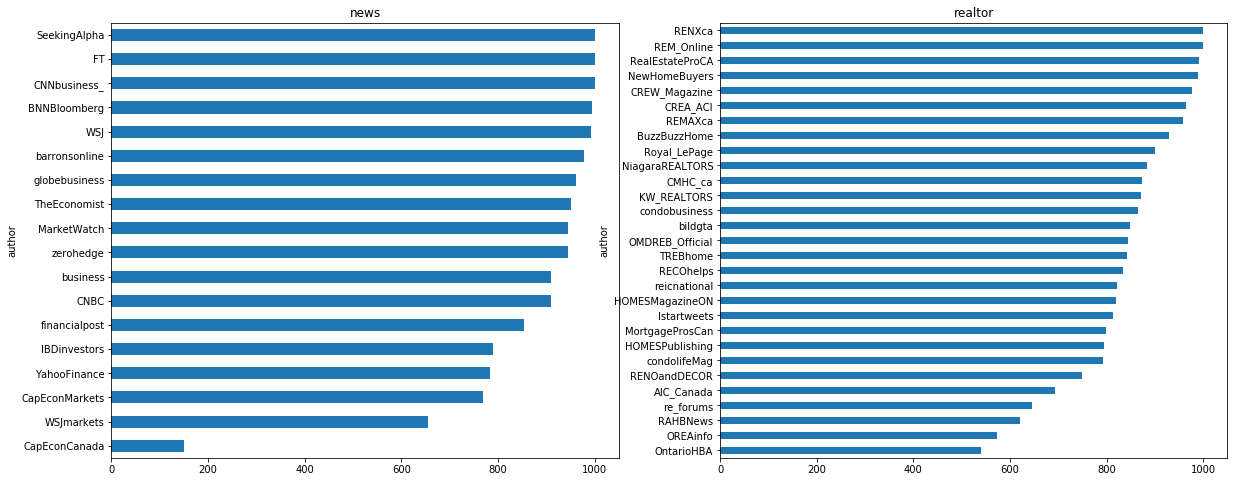

In [36]:
# count the number of tweets collected from each news outlet
cntfig = plt.figure(figsize=(20,8))
f1 = cntfig.add_subplot(121)
f1 = news.groupby('author')['tweet_clean'].count().sort_values().plot(kind='barh')
f2 = cntfig.add_subplot(122)
f2 = realtor.groupby('author')['tweet_clean'].count().sort_values().plot(kind='barh')
axes = cntfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

In [37]:
def find_sent(df):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['tweet_clean'].apply(lambda t: analyzer.polarity_scores(t)['compound'])
    focus = df[['author','date','tweet_clean','sentiment']]
    focus = df[['author','date','tweet_clean','sentiment']]
    filter_time = focus['date'] >= datetime(2019,1,1)
    recent = focus[filter_time].set_index('date')
    return recent

In [38]:
news_recent = find_sent(news)
realtor_recent = find_sent(realtor)
searched_recent = find_sent(searched)

In [75]:
def sent_trend(df):
    grouper = df.groupby(pd.Grouper(freq='M'))
    groupby_month = grouper.mean().reset_index()
    f = plt.scatter(x=groupby_month['date'],y=groupby_month['sentiment'], linewidths=1)
    return f

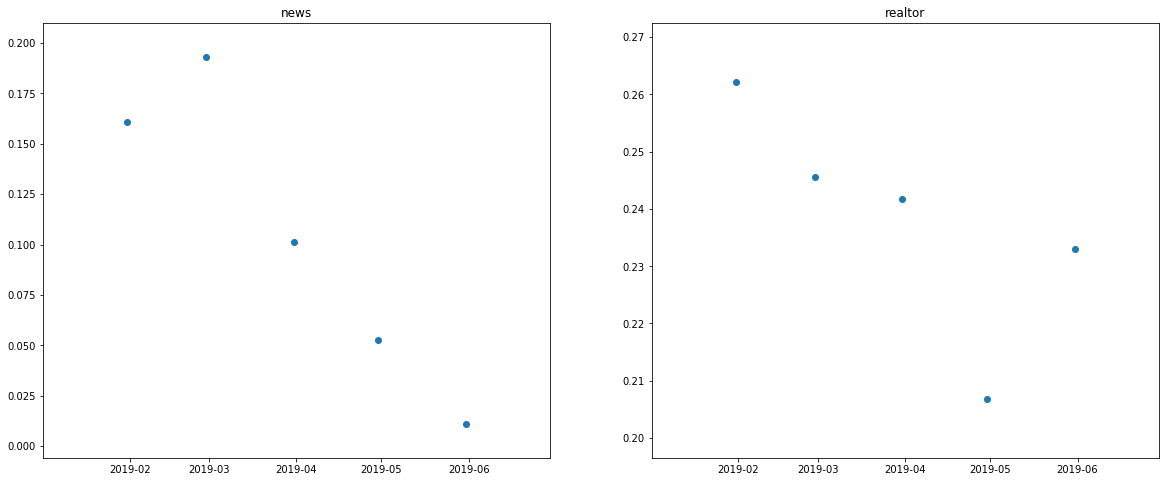

In [76]:
trendfig = plt.figure(figsize=(20,8))
fn = trendfig.add_subplot(121)
fn = sent_trend(news_recent)
fr = trendfig.add_subplot(122)
fr = sent_trend(realtor_recent)
axes = trendfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

In [41]:
def sent_ingroup(df):
    groupby_author = df.groupby('author').mean().reset_index().sort_values('sentiment')
#     f = groupby_author.plot(x='author',kind='barh', figsize = (8,6))
    f = plt.barh(groupby_author['author'], groupby_author['sentiment'])
    return f

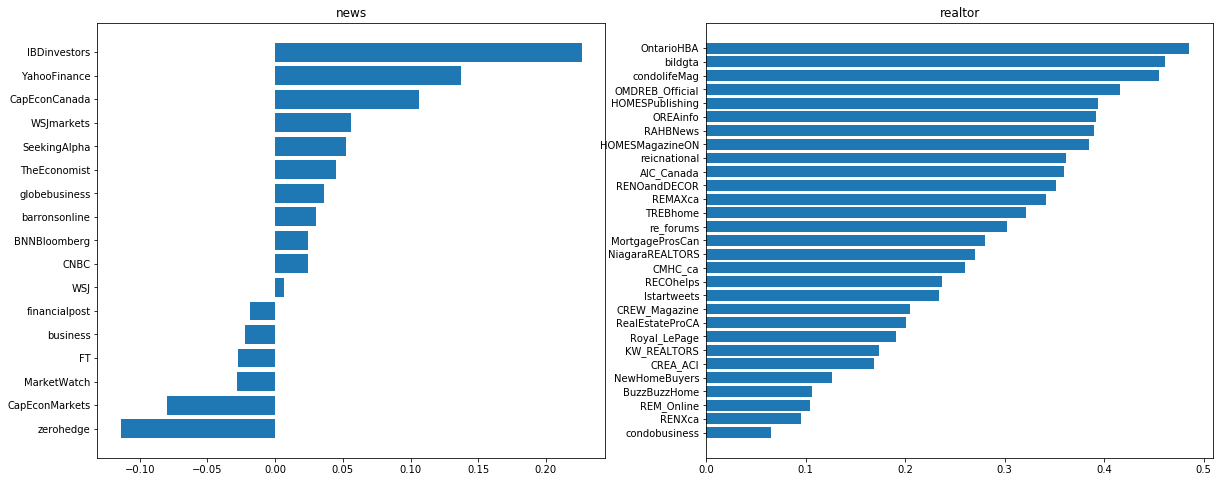

In [42]:
groupfig = plt.figure(figsize=(20,8))
fn = groupfig.add_subplot(121)
fn = sent_ingroup(news_recent)
fr = groupfig.add_subplot(122)
fr = sent_ingroup(realtor_recent)
axes = groupfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

## Price

In [43]:
df_pg = df_p.groupby(by=['city','proptype']).median().reset_index()

In [44]:
df_pg.columns = ['city','proptype','median_ask']

In [45]:
df_ppivot = df_pg.pivot(index='proptype',columns='city',values='median_ask')
df_ppivot

city,Aurora,Burlington,Hamilton,Markham,Milton,Mississauga,Newmarket,Oakville,Oshawa,Pickering,Richmond Hill,Toronto,Vaughan
proptype,,,,,,,,,,,,,
Apartment,"687,000","410,950","375,000","549,900",nan,"464,950",nan,"594,900",nan,nan,"515,400","624,500","559,500"
Bungalow,"2,190,000","897,000","494,350","1,188,999","1,199,750","1,012,400","799,000","1,099,000","554,900","2,020,000","1,253,800","850,000","1,514,900"
Detached,"1,158,000","979,500","562,000","1,339,400","877,950","1,267,500","876,950","1,414,450","619,900","894,450","1,459,444","1,293,000","1,399,450"
Loft,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"796,000",nan
Semi-Detached,nan,nan,"449,450","993,950",nan,"772,450",nan,nan,"624,450",nan,nan,"899,900","864,450"
Townhouse,"790,500","599,994","517,450","799,000","599,950","666,950","722,445","789,000","459,450","519,939","876,400","704,500","859,000"


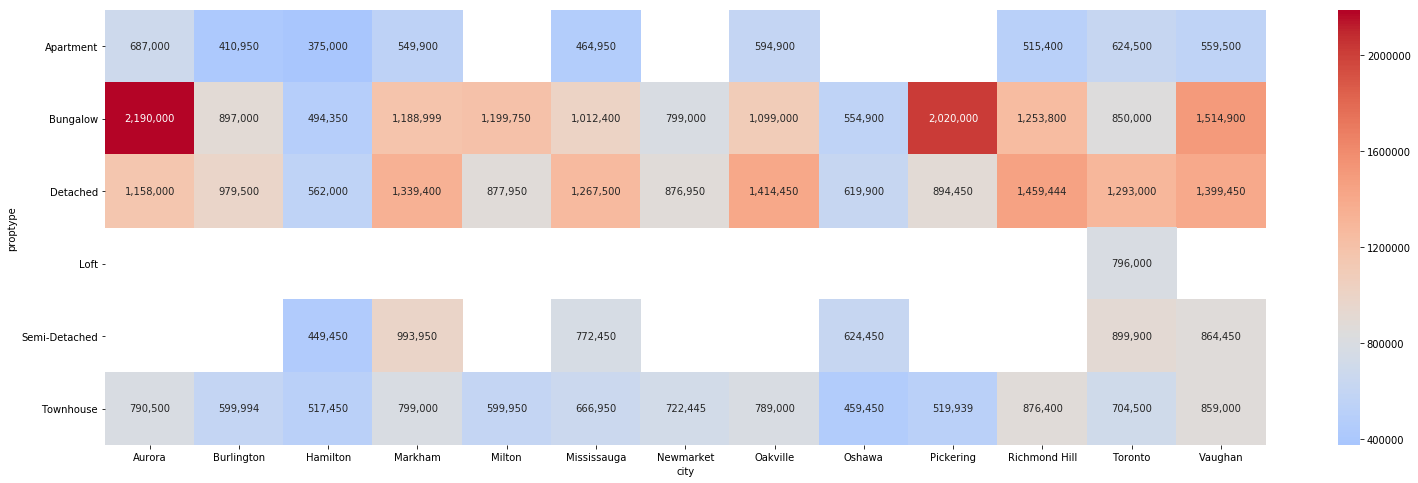

In [74]:
fig, ax = plt.subplots(figsize=(26,8))
sns_plot=sns.heatmap(data=df_ppivot,cmap="coolwarm",center=df_ppivot.mean(axis=1).mean(),annot=True,fmt=',.0f')

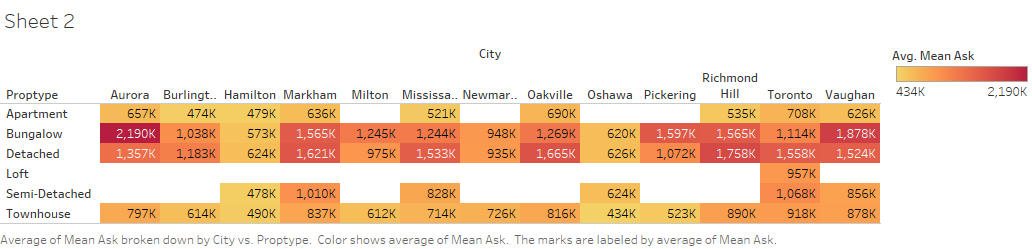

In [78]:
from IPython.display import Image
Image(filename='Sheet 2.png') 

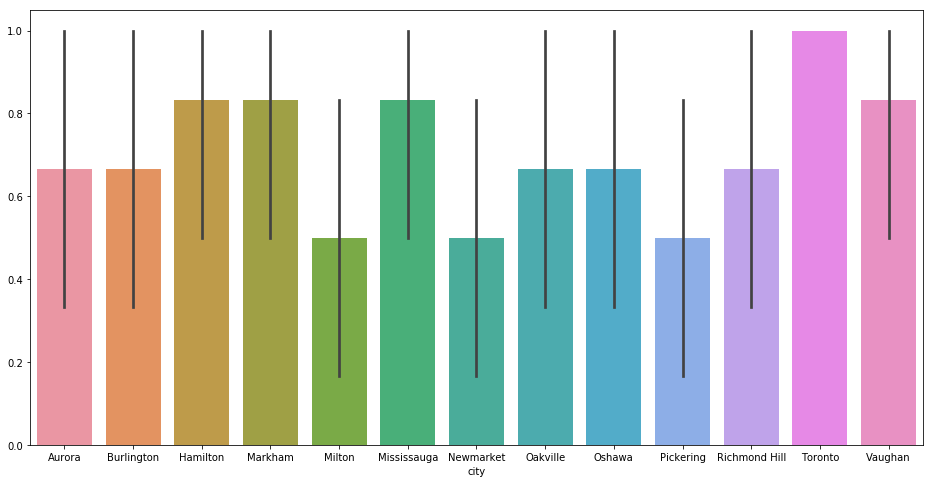

In [47]:
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data= df_ppivot.notnull())